In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [4]:
# !unzip gdrive/MyDrive/data.zip > /dev/null

# Cat-Dog classification using transfer learning
###### Charlie Rosander 2023-09
A while back I made a Cat-Dog-CNN project, which was a simple CNN model classifying cats and dogs. Running 100 Epochs I would get around 80-85% accuracy, so now I want to try the same dataset* (see conclusion) but with transfer learning, to see if I can get a better result with fewer epochs etc. We will be using MobileNetV2 but freezing the base model and applying our own classification layer to it. We will then train it and see how it performs, and compare with our own model. My own model is very simple, so we will just recreate it in this notebook for simpliciy's sake.

The dataset is from Kaggle: https://www.microsoft.com/en-us/download/details.aspx?id=54765

In [5]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications import MobileNetV2
import shutil
import pandas as pd

We start by preparing some variables.

In [6]:
# Preparing directory vars
base_dir = os.getcwd() + '/data'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

print(f"""
{base_dir},
{train_dir},
{test_dir}
""")

# Prepare image parameter vars
BATCH_SIZE = 32
IMG_SIZE = (96, 96)



c:\Users\Kaliber\Desktop\AI-Developer-Jensen\AI-kursen\Uppgifter\Exam-DL/data,
c:\Users\Kaliber\Desktop\AI-Developer-Jensen\AI-kursen\Uppgifter\Exam-DL/data\train,
c:\Users\Kaliber\Desktop\AI-Developer-Jensen\AI-kursen\Uppgifter\Exam-DL/data\test



### Data preprocessing
Here we use the ImageDataGenerator to load the images from the directories. I have split the data up into train, val and test in the directories, each with their respective subfolders (cat/dog).

We are also using MobileNetV2's preprocessing method as the preprocessing_function.
ImageDataGenerator automatically labels the images into classes based on the subfolders.

In [7]:
# Preparing the preprocess method
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create an ImageDataGenerator object with rescaling and validation split
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2  # 20% for validation
)

# Create a test ImageDataGenerator object only with rescaling
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

# Training data: 80% from train directory
train_gen = train_datagen.flow_from_directory(train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"  # set as training data
)

# Validation data: 20% from train directory
val_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"  # set as validation data
)

# Test data: Take all images from test directory
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)


Found 16000 images belonging to 2 classes.
Found 3999 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.


### Inspecting the data
We will inspect the data a bit more to see that everything is in order.

In [8]:
# Here we inspect the classes to verify that they are correct.

print("Training class indices:", train_gen.class_indices)
print("Validation class indices:", val_gen.class_indices)
print("Test class indices:", test_gen.class_indices)


Training class indices: {'cat': 0, 'dog': 1}
Validation class indices: {'cat': 0, 'dog': 1}
Test class indices: {'cat': 0, 'dog': 1}


In [9]:
# Inspect batch size and shape
for image_batch, label_batch in train_gen:
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    break

Image batch shape: (32, 96, 96, 3)
Label batch shape: (32,)


Inspecting the images: we are using MobileNets preprocessing which normalizes the images to a range of -1 to 1, which causes an irritating warning to pop up when doing this inspection, so just for the purpose of demonstration we modify the values to be between 0-1, which is what matplot expects.

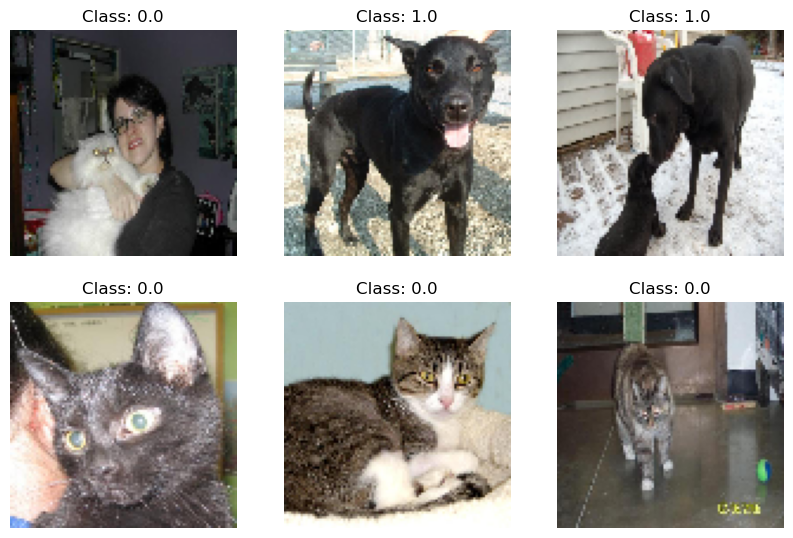

In [10]:
# Inspecting the images. Looks absolutely fantastic.
x_batch, y_batch = next(train_gen)

plt.figure(figsize=(10, 10), facecolor='white')
for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((x_batch[i] + 1) / 2.0)
    plt.title(f"Class: {y_batch[i]}")
    plt.axis('off')


### Creating the model, using the base model MobileNetV2.
We will use the pretrained model MobileNetV2 as our base model, and we will not include the top layer as we will add our own classifier layer and train it ourselves, as well as freeze the base model so we don't have to retrain it.

In [11]:
# Creating the base model MobileNetV2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

In [12]:
# Here we retrieve a batch of images and their labels from train_gen,
# pass them through the base model to extract the features and then prints the shape

image_batch, label_batch = next(iter(train_gen))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 3, 3, 1280)


In [13]:
# Freezing the base model
base_model.trainable = False

In [14]:
# Inspect the base model
base_model.summary()

Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 Conv1 (Conv2D)                 (None, 48, 48, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 48, 48, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 48, 48, 32)   0           ['bn_Conv1[0][0]']               
                                                                                

### Classification head
We need to add a classification head to the model, this is the layer that we will train and make predictions with. We will also convert the features to a single 1280-element vector.

In [15]:
# Converting the features to a single 1280-element vector per image

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
# Adding a prediction layer
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


### Putting it all together
We will now put all the parts together, as well as some last minute data-augmentation because I forgot to write it earlier in the code.

In [17]:
# Some data augmentation
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip(
    'horizontal'), tf.keras.layers.RandomRotation(0.2),])

inputs = tf.keras.Input(shape=(IMG_SIZE[0],IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 96, 96, 3)         0         
                                                                 
 mobilenetv2_1.00_96 (Functi  (None, 3, 3, 1280)       2257984   
 onal)                                                           
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281  

We can see in the output above that we now have 1,281 trainable parameters, which is from the classification head we added. These will be trained, while the base model will be frozen.

In [18]:
# Compile the model
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training the model: When training the model we get a warning message from PIL, (UserWarning: Truncated File Read
warnings.warn(str(msg))). This is most likely related to the dataset, but I have not found a way to resolve it, although this doesn't seem to affect the training or program from what i've read or noticed myself.


In [23]:
# Var for the number of epochs
epoch_num = 5

# Train the actual model
history = model.fit(train_gen, epochs=epoch_num, validation_data=val_gen)

Epoch 1/5
500/500 [==============================] - 58s 117ms/step - loss: 0.2316 - accuracy: 0.9002 - val_loss: 0.1292 - val_accuracy: 0.9487
Epoch 2/5
500/500 [==============================] - 59s 119ms/step - loss: 0.2181 - accuracy: 0.9049 - val_loss: 0.1232 - val_accuracy: 0.9517
Epoch 3/5
500/500 [==============================] - 60s 120ms/step - loss: 0.2036 - accuracy: 0.9089 - val_loss: 0.1189 - val_accuracy: 0.9530
Epoch 4/5
500/500 [==============================] - 61s 122ms/step - loss: 0.2045 - accuracy: 0.9114 - val_loss: 0.1185 - val_accuracy: 0.9555
Epoch 5/5
500/500 [==============================] - 60s 120ms/step - loss: 0.2060 - accuracy: 0.9141 - val_loss: 0.1147 - val_accuracy: 0.9560


### Plotting and evaluation

As we can see in the val_accuracy above, the model is so efficient that we only need to run it for a few epochs to get a good result. This affects the graph, making it quite uninformative/unneccesary since it's covering such a short time span. 

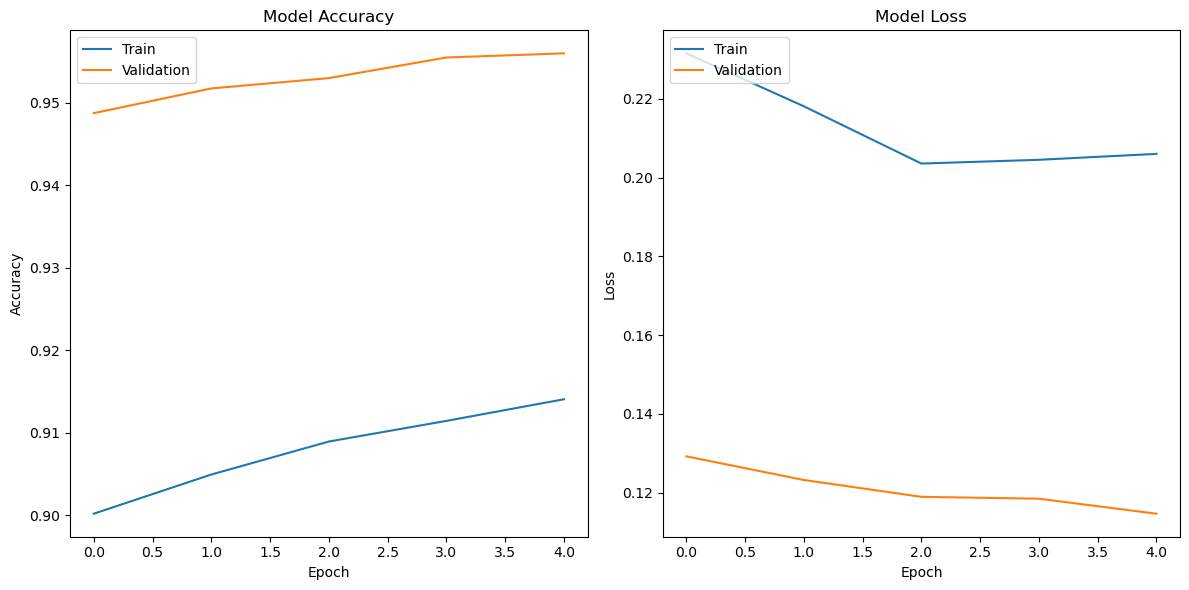

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


### Testing of the model
Here we test the model on the test data which is completely seperate from the training and validation data. We can see that we get almost 95% accuracy after only 5 epochs, which is simply amazing compared to my own model which got around 80-85% after 100 epochs.

157/157 - 14s - loss: 0.1205 - accuracy: 0.9536 - 14s/epoch - 91ms/step

Test accuracy: 0.9535906910896301

Test loss: 0.12046077102422714
1/1 [==============================] - 0s 65ms/step


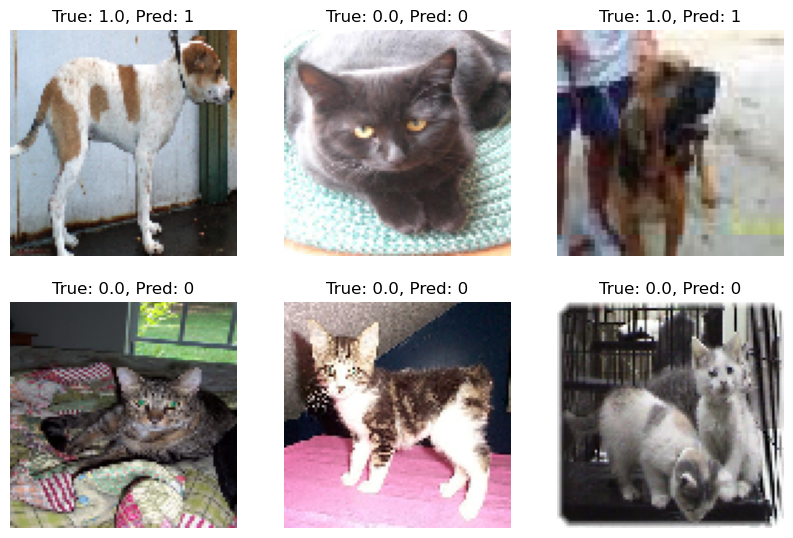

In [25]:
# Test the model
test_loss, test_acc = model.evaluate(test_gen, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

# Get a test batch
test_images, test_labels = next(test_gen)

# Make predictions
predictions = model.predict(test_images)

# Convert logits to label indexes
predicted_labels = [1 if x > 0 else 0 for x in predictions]

# Select 6 random images and their corresponding labels and predictions
rand_indices = random.sample(range(len(test_images)), 6)

plt.figure(figsize=(10, 10), facecolor='white')

for i, idx in enumerate(rand_indices):
    ax = plt.subplot(3, 3, i + 1)
    
    # Convert the image range back to [0, 1] for display
    plt.imshow((test_images[idx] + 1) / 2.0)
    
    plt.title(f"True: {test_labels[idx]}, Pred: {predicted_labels[idx]}")
    plt.axis('off')


# Model comparison
In this section we will run the same model that I used in my own Cat-Dog-CNN project. As the dataset used in this project is larger, I will not use the same parameters as I did in the other project because it would take too long to train, but to make things fair I will atleast run it for a decent amount of epochs and see what the results are.

In [26]:
# Create an ImageDataGenerator object with rescaling and validation split
train_comp_datagen = ImageDataGenerator(
    validation_split=0.2  # 20% for validation
)

# Create a test ImageDataGenerator object only with rescaling
test_comp_datagen = ImageDataGenerator(
)

# Training data: 80% from train directory
train_comp_gen = train_comp_datagen.flow_from_directory(train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"  # set as training data
)

# Validation data: 20% from train directory
val_comp_gen = train_comp_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"  # set as validation data
)

# Test data: Take all images from test directory
test_comp_gen = test_comp_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

# Here we inspect the classes to verify that they are correct.
print("Training class indices:", train_comp_gen.class_indices)
print("Validation class indices:", val_comp_gen.class_indices)
print("Test class indices:", test_comp_gen.class_indices)

# Inspect batch size and shape
for image_batch, label_batch in train_comp_gen:
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)
    break

# Normalize pixel values to [0, 1] for all datasets
train_comp_gen = ((x / 255.0, y) for x, y in train_comp_gen)
val_comp_gen = ((x / 255.0, y) for x, y in val_comp_gen)
test_comp_gen = ((x / 255.0, y) for x, y in test_comp_gen)


Found 16000 images belonging to 2 classes.
Found 3999 images belonging to 2 classes.
Found 4999 images belonging to 2 classes.
Training class indices: {'cat': 0, 'dog': 1}
Validation class indices: {'cat': 0, 'dog': 1}
Test class indices: {'cat': 0, 'dog': 1}
Image batch shape: (32, 96, 96, 3)
Label batch shape: (32,)


### Recreating my own model
Here I am recreating my own model. Since it is such a simple model I found it easier to just recreate it here instead of importing it from the other project.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define hyperparameters
input_shape = (96, 96, 3)
regularizer = l2(0.001)
batch_size = 32
epochs = 50

# Create the model
model_compare = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_regularizer=regularizer),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizer),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=regularizer),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_compare.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Train the model
history_compare = model_compare.fit(train_gen, epochs=epochs, validation_data=val_gen)

# Save the model
# model_compare.save(saved_model_path)


Epoch 1/50
500/500 [==============================] - 83s 164ms/step - loss: 0.7671 - accuracy: 0.6202 - val_loss: 0.6338 - val_accuracy: 0.6944
Epoch 2/50
500/500 [==============================] - 73s 146ms/step - loss: 0.5991 - accuracy: 0.7082 - val_loss: 0.5668 - val_accuracy: 0.7344
Epoch 3/50
500/500 [==============================] - 74s 148ms/step - loss: 0.5574 - accuracy: 0.7472 - val_loss: 0.5261 - val_accuracy: 0.7814
Epoch 4/50
500/500 [==============================] - 72s 144ms/step - loss: 0.5203 - accuracy: 0.7792 - val_loss: 0.4802 - val_accuracy: 0.8060
Epoch 5/50
500/500 [==============================] - 71s 143ms/step - loss: 0.4982 - accuracy: 0.7967 - val_loss: 0.4728 - val_accuracy: 0.8130
Epoch 6/50
302/500 [=================>............] - ETA: 24s - loss: 0.4849 - accuracy: 0.8069

KeyboardInterrupt: 

In [28]:
# Test the model
test_loss, test_acc = model_compare.evaluate(test_gen, verbose=2)

157/157 - 13s - loss: 0.4829 - accuracy: 0.8060 - 13s/epoch - 84ms/step


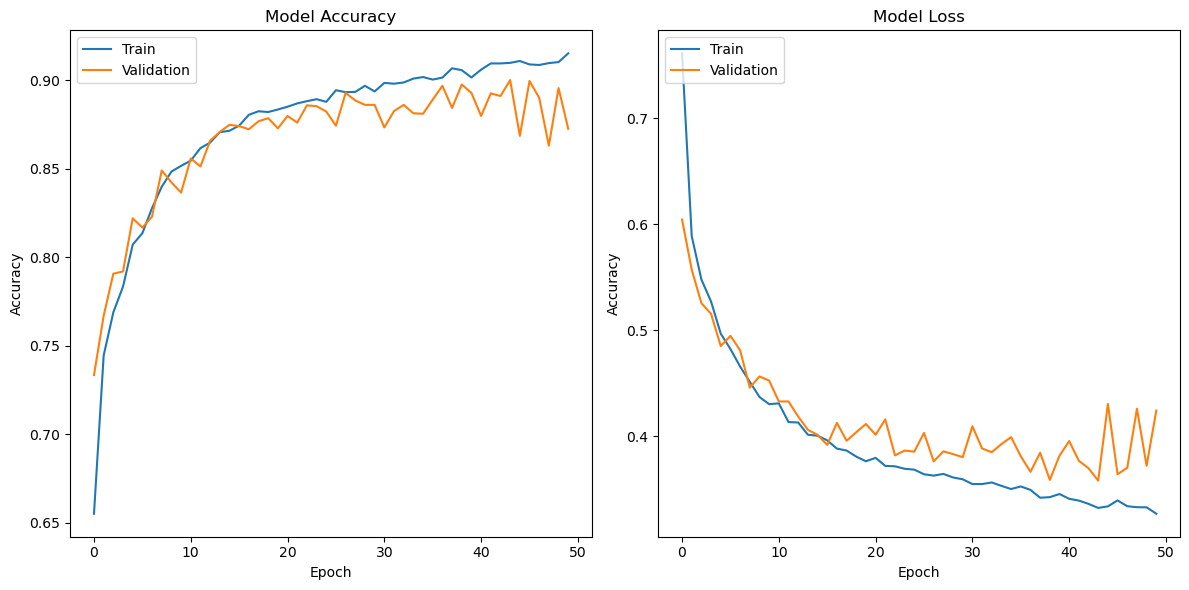

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_compare.history['accuracy'])
plt.plot(history_compare.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_compare.history['loss'])
plt.plot(history_compare.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# Conclusion

### Dataset

The dataset is the same dataset that I used for my other model. It is a dataset of 25,000 images of cats and dogs, which originally wasn't split up into train/test, so I did that with a script to easier be able to use it in this project with ImageDataGenerator. I split the data into train, validation and test, with 16000 train, 3999 validation and 4999 test images. The reason for the odd validation and test numbers is because I noticed that there were corrupted images in the dataset, so I had to make another script identifying and removing those images, like a true hackerman.

*Although this is the same dataset used in my other project, I used far fewer pictures in the other project, so I realise that it's not a completely fair comparison, but it's shows us something quite important: Data is key! Since we are doing the comparison again in this project, we can see that the model performs much better with more data, since nothing else is changed except for running it for fewer epochs, which I would think would make it perform worse, but it doesn't. 

### Model

Much of this is covered earlier in the notebook, but to summarize; We use MobileNetV2, freeze the base model and add our own classification head. We are also using ImageDataGenerator to load and label the images from the directories, and we are using MobileNetV2's preprocessing method as the preprocessing_function. The comparison model is my own simple model, which is comprised of 3 convolutional layers, 3 max-pooling layers, 2 dropout layers, 1 flatten layer, and 2 dense layers.

### Results

The results are quite staggering, as this model basically shows over 90% accuracy out of the box on the first epoch, and after 5 epochs we are already at 95% accuracy. What didn't expect was how my own model performed. I ran it for 50 epochs and expected it to perform worse than before, but it quite quickly reached above 85% accuracy, which is most likely due to the larger dataset used.

### Improvements

- Model

  There's not much for me to say about the model itself since it's not my own, and since it's so efficient and accurate. There is of course ways to improve it, for example in my own classification layer but I didn't have the time to play around with that. My own model could be improved in several ways, but that is not what this project is about.

- Dataset

  The dataset is quite large which is good, compared to what I've worked with in past projects. However, when training the model, some kind of wierd message pops up, and I haven't found a solution to it. Searching around tells me that it is most likely a problem with the data, like another corrupted image or the like, which would make sense since I found 2 other corrupted images, but I removed them so it's hard to tell. The program and training still seems to run fine though so I don't know what to make of it. This is something that in future projects I would like to resolve, but for the purpose of this project it's not really necessary.

- Computational load

  This is probably the biggest "problem" with this code. The dataset is large, and the model only takes 96x96 as the smallest resolution, so the training time is quite "long". I would like to run this for many more epochs, but for the purpose of this project I don't felt it really necessary to reduce the dataset etc.

- Code

  The code could be more structured, and I could have used more functions to make it more readable/efficient, but since this is a demonstrational notebook I felt it was unnecessary, especially since the purpose of this project is just to compare the models themselves.

- Results

  The results are great, but they are not perfect. I don't even know if this is possible to achieve, but I am sure that with more epochs and tinkering with the model and parameters, it would be possible to reach 98-99%.

### Reflections

This has been a very eye-opening project. Seeing both the efficiancy and time-saving of using transfer learning, as well as the amazing results, it almost feels like cheating.
I am amazed at how quickly the model learned to classify the images, and how easy it was to set up. I spent countless hours on my own model, and while im proud of how it performs, it is nothing compared to this.

Of course you can't really compare models side by side like that, and there are many factors that come into play, for example I actually used many more images in this model, due to the fact that I already knew that I would be able to run it for much fewer epochs, but even then I am sure my own model would not be able to perform as well as this one.

If you are interested in seeing my other project as a whole, you can find it here: https://github.com/CharlieRosander/AI-kursen/blob/main/Uppgifter/ImageRecognitionCNN/main.py.

